In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
!pip install nvcc4jupyter

In [3]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpja3sym1e".


In [11]:
%%cuda
#include <curand_kernel.h>  // Библиотека для генерации случайных чисел на GPU
#include <thrust/device_vector.h>  // Библиотека Thrust для работы с векторами на GPU
#include <iostream>
#include <vector>
#include <cuda_runtime.h>
#include <chrono>
#include <thrust/host_vector.h>  // Вектор для хост-системы (CPU)
#include <thrust/extrema.h>  // Функции для поиска экстремумов (min/max)

// Функция приспособленности
__device__ float evaluateFitness(const float* coefficients, const float* pointsX, const float* pointsY, int degree, int numPoints) {
    float mse = 0.0f;  // Переменная для накопления среднеквадратичной ошибки (Mean Squared Error)
    for (int i = 0; i < numPoints; ++i) {
        float predictedY = 0.0f;  // Предсказанное значение Y
        for (int j = 0; j <= degree; ++j) {
            predictedY += coefficients[j] * powf(pointsX[i], j);  // Вычисляем значение полинома
        }
        float error = predictedY - pointsY[i];  // Разница между предсказанным и реальным значением
        mse += error * error;  // Накопление квадрата ошибки
    }
    return mse / numPoints;  // Возвращаем среднеквадратичную ошибку
}

// Функция для выбора лучшего индивидуума с помощью турнира (10 случайных)
__device__ int tournamentSelection(float* fitness, int populationSize, curandState* state) {
    int bestIndividual = -1;
    float bestFitness = FLT_MAX;
    for (int i = 0; i < 10; ++i) {
        int individual = curand(state) % populationSize;
        if (fitness[individual] < bestFitness) {
            bestFitness = fitness[individual];
            bestIndividual = individual;
        }
    }
    return bestIndividual;
}

// Функция кроссовера для скрещивания двух родителей и создания потомка
__device__ void crossover(const float* parent1, const float* parent2, float* child, int degree, curandState* state) {
    int crossoverPoint = 1 + (curand(state) % degree);  // Определяем точку кроссовера (где гены будут обмениваться)
    for (int i = 0; i < degree + 1; ++i) {
        if (i < crossoverPoint) child[i] = parent1[i];  // Гены от первого родителя до точки кроссовера
        else  child[i] = parent2[i];  // Гены от второго родителя после точки кроссовера
    }
}

// Функция мутации для изменения генов индивидуума
__device__ void mutate(float* individual, int degree, curandState* state) {
    for (int i = 0; i <= degree; ++i) individual[i] += curand_uniform(state) - 0.5f;
}

// Ядро для вычисления приспособленности (fitness) каждого индивидуума в популяции
__global__ void geneticAlgorithmKernel(float* population, float* pointsX, float* pointsY, float* fitness, int populationSize, int degree, int numPoints, curandState* states) {
    int idx = threadIdx.x + blockDim.x * blockIdx.x;
    if (idx < populationSize) {
        curand_init(1234, idx, 0, &states[idx]);  // Инициализация генератора случайных чисел для каждого индивидуума
        fitness[idx] = evaluateFitness(&population[idx * (degree + 1)], pointsX, pointsY, degree, numPoints);  // Вычисление приспособленности
    }
}

// Ядро для создания нового поколения на основе предыдущего с возможностью мутации
__global__ void nextGeneration(float* population, float* newPopulation, float* fitness, int populationSize, int degree, bool applyMutation, curandState* states) {
    int idx = threadIdx.x + blockDim.x * blockIdx.x;
    if (idx < populationSize) {
        curandState localState = states[idx];
        int parent1Idx = tournamentSelection(fitness, populationSize, &localState);  // Выбор первого родителя с помощью турнира
        int parent2Idx = tournamentSelection(fitness, populationSize, &localState);  // Выбор второго родителя
        float* parent1 = &population[parent1Idx * (degree + 1)];  // Указатель на первого родителя
        float* parent2 = &population[parent2Idx * (degree + 1)];  // Указатель на второго родителя

        float* child = &newPopulation[idx * (degree + 1)];  // Указатель на потомка
        crossover(parent1, parent2, child, degree, &localState);  // Выполнение кроссовера для создания потомка
        if (applyMutation) {
            mutate(child, degree, &localState);  // Выполнение мутации, если это необходимо
        }
    }
}

int main() {
    setlocale(LC_ALL, "RU");
    int degree = 4; // Степень полинома
    int numPoints = 500; // Количество точек для аппроксимации
    int populationSize = 1000; // Размер популяции (количество особей)
    int maxGenerations = 1000; // Максимальное количество поколений (итераций)

    // Инициализация массивов для точек X и Y
    std::vector<float> hostPointsX(numPoints);
    std::vector<float> hostPointsY(numPoints);
    // Заполняем массивы точек X и Y значениями
    for (int i = 0; i < numPoints; ++i) {
        hostPointsX[i] = static_cast<float>((i + 1) / 50);
        hostPointsY[i] = 5 * hostPointsX[i] * hostPointsX[i] * hostPointsX[i] * hostPointsX[i] +
            3 * hostPointsX[i] * hostPointsX[i] * hostPointsX[i] +
            1 * hostPointsX[i] * hostPointsX[i] +
            2 * hostPointsX[i] + 4;
    }
    // Инициализация популяции случайными коэффициентами полиномов
    std::vector<float> hostPopulation(populationSize * (degree + 1));
    for (int i = 0; i < populationSize * (degree + 1); ++i) {
        hostPopulation[i] = static_cast<float>(rand()) / RAND_MAX;
    }

    // Указатели для размещения данных на GPU
    float* devicePopulation, * devicePointsX, * devicePointsY, * deviceFitness, * deviceNewPopulation;
    cudaMalloc(&devicePopulation, populationSize * (degree + 1) * sizeof(float)); // Память для популяции
    cudaMalloc(&deviceNewPopulation, populationSize * (degree + 1) * sizeof(float)); // Память для новой популяции
    cudaMalloc(&devicePointsX, numPoints * sizeof(float)); // Память для X
    cudaMalloc(&devicePointsY, numPoints * sizeof(float)); // Память для Y
    cudaMalloc(&deviceFitness, populationSize * sizeof(float)); // Память для значений приспособленности

    // Копируем данные из хоста (CPU) в устройство (GPU)
    cudaMemcpy(devicePopulation, hostPopulation.data(), populationSize * (degree + 1) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(devicePointsX, hostPointsX.data(), numPoints * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(devicePointsY, hostPointsY.data(), numPoints * sizeof(float), cudaMemcpyHostToDevice);

    // Создаем генераторы случайных чисел для каждого потока
    curandState* deviceStates;
    cudaMalloc(&deviceStates, populationSize * sizeof(curandState)); // Память для генераторов случайных чисел

    float bestFitness = 1e16f; // Начальное лучшее значение ошибки
    std::vector<float> bestCoefficients(degree + 1); // Вектор для хранения лучших коэффициентов полинома
    float previousBestFitness = 1e16f; // Переменная для отслеживания предыдущей лучшей ошибки
    int generation = 0; // Номер текущего поколения
    int repeatCount = 0; // Счетчик повторений одинаковой ошибки

    // Таймеры для измерения времени выполнения
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    // Основной цикл поколений
    for (generation; generation < maxGenerations; ++generation) {
        // Запуск ядра для вычисления приспособленности
        geneticAlgorithmKernel<<<populationSize / 1024+1, 1024 >>>(devicePopulation, devicePointsX, devicePointsY, deviceFitness, populationSize, degree, numPoints, deviceStates);
        cudaDeviceSynchronize();

        // Определяем, нужно ли включать мутацию (если ошибка повторяется 4 раз)
        bool applyMutation = (repeatCount >= 4);

        // Генерация следующего поколения
        nextGeneration << <populationSize/1024+1, 1024 >> > (devicePopulation, deviceNewPopulation, deviceFitness, populationSize, degree, applyMutation, deviceStates);
        cudaDeviceSynchronize();

        // Копируем обновленную популяцию обратно на хост
        cudaMemcpy(hostPopulation.data(), deviceNewPopulation, populationSize * (degree + 1) * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(devicePopulation, deviceNewPopulation, populationSize * (degree + 1) * sizeof(float), cudaMemcpyHostToDevice);

        // Поиск наименьшего значения приспособленности с помощью Thrust
        thrust::device_ptr<float> dev_ptr(deviceFitness);
        thrust::device_ptr<float> min_ptr = thrust::min_element(dev_ptr, dev_ptr + populationSize);
        bestFitness = *min_ptr; // Находим лучшее значение

        // Индекс лучшего полинома
        int bestIndex = min_ptr - dev_ptr;
        // Копируем коэффициенты лучшего полинома
        std::copy(hostPopulation.begin() + bestIndex * (degree + 1), hostPopulation.begin() + (bestIndex + 1) * (degree + 1), bestCoefficients.begin());

        // Если ошибка не улучшилась, увеличиваем счетчик повторений
        if (bestFitness == previousBestFitness) repeatCount++;
        else repeatCount = 0; // Сбрасываем счетчик, если ошибка уменьшилась
        previousBestFitness = bestFitness; // Обновляем лучшее значение
        if (bestFitness < 0.1) break;  // Прерываем цикл, если ошибка достаточно мала
    }

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop); // Измеряем время выполнения
    std::cout << "Время выполнения на GPU: " << milliseconds / 1000.0f << " секунд" << std::endl; // Вывод времени

    // Вывод лучших коэффициентов полинома
    std::cout << "Лучшие коэффициенты полинома: ";
    for (float coeff : bestCoefficients) {
        std::cout << coeff << " ";
    }
    std::cout << std::endl;
    // Вывод лучшего значения приспособленности и количества итераций
    std::cout << "Лучшая приспособленность: " << bestFitness << std::endl;
    std::cout << "Количество итераций: " << generation << std::endl;
    // Запись результатов в файл


    for (int i = 0; i < numPoints; ++i) {
        if (i == 0 || hostPointsX[i] != hostPointsX[i-1]) {
            float predictedY = 0.0f;
            // Вычисляем предсказанные значения Y по найденным коэффициентам
            for (int j = 0; j <= degree; ++j) {
                predictedY += bestCoefficients[j] * powf(hostPointsX[i], j); // Полином
            }
            printf("x = %f, y = %f, cuda_y = %f\n", hostPointsX[i], hostPointsY[i], predictedY);
        }

    }


    cudaFree(devicePopulation);
    cudaFree(deviceNewPopulation);
    cudaFree(devicePointsX);
    cudaFree(devicePointsY);
    cudaFree(deviceFitness);
    cudaFree(deviceStates);

    return 0;
}

Время выполнения на GPU: 2.14349 секунд
Лучшие коэффициенты полинома: -1.35926 17.2916 -6.39239 4.22828 4.9339 
Лучшая приспособленность: 10.9959
Количество итераций: 1000
x = 0.000000, y = 4.000000, cuda_y = -1.359264
x = 1.000000, y = 15.000000, cuda_y = 18.702084
x = 2.000000, y = 116.000000, cuda_y = 120.422852
x = 3.000000, y = 505.000000, cuda_y = 506.792938
x = 4.000000, y = 1500.000000, cuda_y = 1499.215698
x = 5.000000, y = 3539.000000, cuda_y = 3537.508301
x = 6.000000, y = 7180.000000, cuda_y = 7179.900391
x = 7.000000, y = 13101.000000, cuda_y = 13103.037109
x = 8.000000, y = 22100.000000, cuda_y = 22101.974609
x = 9.000000, y = 35095.000000, cuda_y = 35090.183594
x = 10.000000, y = 53124.000000, cuda_y = 53099.550781



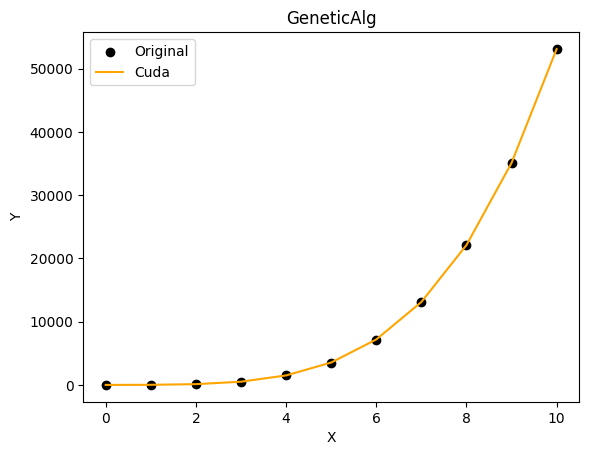

In [12]:
import matplotlib.pyplot as plt

x = [i for i in range(11)]
true_y = [4, 15, 116, 505, 1500, 3539, 7180, 13101, 22100, 35095, 53124]
cuda_y = [-1.359264, 18.702084, 120.422852, 506.792938, 1499.215698, 3537.508301,
          7179.900391, 13103.037109, 22101.974609, 35090.183594, 53099.550781]

plt.scatter(x, true_y, color='black', label='Original')
plt.plot(x, cuda_y, color='orange', label='Cuda')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('GeneticAlg')
plt.show()